<a href="https://colab.research.google.com/github/rcarvajal208/ProyectoMachine/blob/master/P2-Punto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Se instalan e importan las librerias




In [38]:
pip install pyEDFlib

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import math
import zipfile
import pyedflib as pyedf
import numpy as np 
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import LabelEncoder
import keras 
from keras.utils import to_categorical, np_utils
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from imblearn.under_sampling import RandomUnderSampler

#Se cargan los datos

In [0]:
sleep_cassette=zipfile.ZipFile("drive/My Drive/sleep-cassette.zip", mode="r")
sleep_cassette.extractall(None)

In [42]:
data_sleep_cassette = sleep_cassette.namelist()
print(data_sleep_cassette)

['sleep-cassette/', 'sleep-cassette/SC4001E0-PSG.edf', 'sleep-cassette/SC4001EC-Hypnogram.edf', 'sleep-cassette/SC4002E0-PSG.edf', 'sleep-cassette/SC4002EC-Hypnogram.edf', 'sleep-cassette/SC4011E0-PSG.edf', 'sleep-cassette/SC4011EH-Hypnogram.edf', 'sleep-cassette/SC4012E0-PSG.edf', 'sleep-cassette/SC4012EC-Hypnogram.edf', 'sleep-cassette/SC4021E0-PSG.edf', 'sleep-cassette/SC4021EH-Hypnogram.edf', 'sleep-cassette/SC4022E0-PSG.edf', 'sleep-cassette/SC4022EJ-Hypnogram.edf', 'sleep-cassette/SC4031E0-PSG.edf', 'sleep-cassette/SC4031EC-Hypnogram.edf', 'sleep-cassette/SC4032E0-PSG.edf', 'sleep-cassette/SC4032EP-Hypnogram.edf', 'sleep-cassette/SC4041E0-PSG.edf', 'sleep-cassette/SC4041EC-Hypnogram.edf', 'sleep-cassette/SC4042E0-PSG.edf', 'sleep-cassette/SC4042EC-Hypnogram.edf', 'sleep-cassette/SC4051E0-PSG.edf', 'sleep-cassette/SC4051EC-Hypnogram.edf', 'sleep-cassette/SC4052E0-PSG.edf', 'sleep-cassette/SC4052EC-Hypnogram.edf', 'sleep-cassette/SC4061E0-PSG.edf', 'sleep-cassette/SC4061EC-Hypnogra

#Se definen las variables 'X' y 'y'

In [43]:
#Se inicializan las variables y equitas
X=[]
Y=[]
y=[]
label1='Despierto'
label2='Sueño Ligero'
label3='Sueño Profundo'
label4='Sueño REM'
#Se recorre el archivo zip para extraer sus datos
for i in range(1, 20): 
  i_psg=2*i-1
  i_hyp=2*i
  st_FileHypEdf = pyedf.EdfReader(data_sleep_cassette[i_hyp])
  st_FileEdf = pyedf.EdfReader(data_sleep_cassette[i_psg])
  #Etiquetas
  v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations()
  
  s_SigNum = st_FileEdf.signals_in_file
  v_Signal_Labels = st_FileEdf.getSignalLabels()

  #Canal 1
  # Conversion a segundos usando frecuencia de muestreo.
  s_SigRef1 = 0
  s_NSamples1 = st_FileEdf.getNSamples()[0]
  s_FsHz1 = st_FileEdf.getSampleFrequency(s_SigRef1)

  # v_Sig = np.zeros((s_NSamples, 1))
  v_Sig1 = st_FileEdf.readSignal(0)
  v_Time1 = np.arange(0, s_NSamples1) / s_FsHz1

  #Canal 2
  # Conversion a segundos usando frecuencia de muestreo.
  s_SigRef2 = 1
  s_NSamples2 = st_FileEdf.getNSamples()[1]
  s_FsHz2 = st_FileEdf.getSampleFrequency(s_SigRef2)

  # v_Sig = np.zeros((s_NSamples, 1))
  v_Sig2 = st_FileEdf.readSignal(1)
  v_Time2 = np.arange(0, s_NSamples2) / s_FsHz2

  #Canal 3
  # Conversion a segundos usando frecuencia de muestreo.
  s_SigRef3 = 2
  s_NSamples3 = st_FileEdf.getNSamples()[2]
  s_FsHz3 = st_FileEdf.getSampleFrequency(s_SigRef3)

  # v_Sig = np.zeros((s_NSamples, 1))
  v_Sig3 = st_FileEdf.readSignal(2)
  v_Time3 = np.arange(0, s_NSamples3) / s_FsHz3

  #Se actualizan las variables del loop principal
  dato_final=0
  dato_inicio=0
  k=0
  m=0
  #Se recorren los distintos atepas de sueño para construir los vectores de X y Y
  for i in v_HypDur:
    mark=False
    #Se verifica la etapa del sueño
    if v_Hyp[k]=='Sleep stage W':
      label=label1
      l=0
      mark=True
    elif v_Hyp[k]=='Sleep stage 1' or v_Hyp[k]=='Sleep stage 2':
      label=label2
      l=1
      mark=True
    elif v_Hyp[k]=='Sleep stage 3' or v_Hyp[k]=='Sleep stage 4':
      label=label3
      l=2
      mark=True
    elif v_Hyp[k]=='Sleep stage R':
      label=label4
      l=3
      mark=True
    #Se organizan los datos que construyen a X
    dato_final=int(i*100+dato_inicio)
    dato1=v_Sig1[dato_inicio:dato_final]
    dato2=v_Sig2[dato_inicio:dato_final]
    dato3=v_Sig3[dato_inicio:dato_final]
    dato=np.array([dato1,dato2,dato3])
    if int(dato.shape[1]/500)>3000:
      dato=dato[:,0:int(dato.shape[1]/2)]
      matriz=dato.reshape(int(dato.shape[1]/500),3, 500).astype(np.float32)
    else:
      matriz=dato.reshape(int(dato.shape[1]/500), 3, 500).astype(np.float32)
    #Se agregan los datos y etiquetas a las variables X y Y
    if mark==True:
      for j in range(len(matriz)):
        X.append(matriz[j])
        Y.append(label)
        y.append(l)
    #Se actualizan las variables del loop interno
    dato_inicio=dato_final
    k=k+1
#Se imprimen la información de Y  
print(Y.count(label1),'Despierto')
print(Y.count(label2),'Sueño ligero')
print(Y.count(label3),'Sueño profundo')
print(Y.count(label4),'Sueño REM') 


111819 Despierto
60138 Sueño ligero
17802 Sueño profundo
20568 Sueño REM


Hacemos un subsampling de los datos para reducir la cantidad de información de la primera variable e igualarla a la de la segunda variable más grande

In [44]:
#Se realiza el subsampling de los datos
X = np.array(X)
n_samples, h, w = X.shape 
X_re = X.reshape((n_samples,h*w))
X_re = preprocessing.scale(X_re)
num=range(len(Y))
X_data = []
Y_data = []
X_data2 = []
Y_data2 = []
for i in num:
  if Y[i]==label1 or Y[i]==label2:
    X_data.append(X_re[i])
    Y_data.append(Y[i])
  else:
    X_data2.append(X_re[i])
    Y_data2.append(Y[i])

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
x_over, y_over = undersample.fit_resample(X_data, Y_data)

x_subsampling = list(x_over)
y_subsampling = list(y_over)
num2=range(len(X_data2))
for i in num2:
  x_subsampling.append(X_data2[i])
  y_subsampling.append(Y_data2[i])

print(y_subsampling.count(label1),'Despierto')
print(y_subsampling.count(label2),'Sueño ligero')
print(y_subsampling.count(label3),'Sueño profundo')
print(y_subsampling.count(label4),'Sueño REM')
print("Total número de datos: ", len(x_subsampling))
x_subsampling = np.array(x_subsampling)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


60138 Despierto
60138 Sueño ligero
17802 Sueño profundo
20568 Sueño REM
Total número de datos:  158646


In [0]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_subsampling)
encoded_Y = encoder.transform(y_subsampling)
# convert integers to dummy variables (i.e. one hot encoded)
Y_categorical = np_utils.to_categorical(encoded_Y)

#Preprocesamiento de datos


1.   Se realiza el conjunto de entrenamiento al tomar el 70% de los datos totales.
2.   Se realiza el conjunto de validación al tomar el 10% de los datos de entrenamiento.



In [46]:
#Se definen los porcentajes de entrenamiento y validación
porcentajeEntrenamiento = 0.7
porcentajeValidación = 0.9
#Se determinan los datos de entrenamiento, prueba y validación
x_entrenamiento0, x_prueba0, y_entrenamiento0, y_prueba = model_selection.train_test_split(x_subsampling, Y_categorical, test_size=1-porcentajeEntrenamiento)
x_entrenamiento0, x_validacion0, y_entrenamiento0, y_validacion = model_selection.train_test_split(x_entrenamiento0, y_entrenamiento0, test_size=1-porcentajeValidación)
#Se imprimen las dimenciones de las variables
print(Y_categorical.shape,'Y_categorical')
print(x_subsampling.shape,'x_subsampling')
print(x_entrenamiento0.shape,'x_entrenamiento0')
print(x_validacion0.shape,'x_validacion0')
print(x_prueba0.shape,'x_prueba0')

(158646, 4) Y_categorical
(158646, 1500) x_subsampling
(99946, 1500) x_entrenamiento0
(11106, 1500) x_validacion0
(47594, 1500) x_prueba0


#Creación de Descriptores
Se utiliza PCA para encontrar los descriptores que agrupan más del 80% de la información de la variabilidad en las variables de entrada

In [47]:
#Se define el número de descriptores
n_components = 200
#Se reduce la cantidad de dimenciones al número especificado por n_components 
pca = PCA(n_components=n_components, svd_solver='auto', whiten=True).fit(x_entrenamiento0)
#Se actualizan las variables de entrenamiento y validación con base en pca
x_entrenamiento_pca = pca.transform(x_entrenamiento0)
x_validacion = pca.transform(x_validacion0)
x_prueba = pca.transform(x_prueba0)
#Se imprimen las dimenciones de las variables
print(x_entrenamiento_pca.shape,'x_entrenamiento_pca')
print(x_validacion.shape,'x_validacion') 
print(x_prueba.shape,'x_prueba')

(99946, 200) x_entrenamiento_pca
(11106, 200) x_validacion
(47594, 200) x_prueba


#Porcentaje de variación de los descriptores

Observamos cual es la variabilidad de los principales 4 descriptores e identificamos el total de variabilidad que se agrupó finalmente

Porcentajes%: [6.28 6.22 5.71 5.67]
Porcentaje_Total%: 96.13999999999992


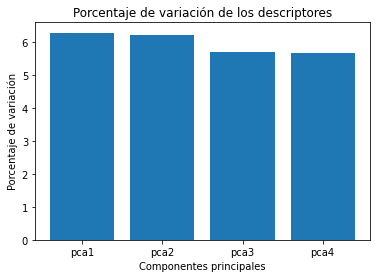

In [48]:
percent_variance = np.round(pca.explained_variance_ratio_*100, decimals =2)
print('Porcentajes%:', percent_variance[0:4])
print('Porcentaje_Total%:',sum(percent_variance))
columns = ['pca1', 'pca2','pca3', 'pca4']
plt.bar(x= range(1,5), height=percent_variance[0:4], tick_label=columns)
plt.ylabel('Porcentaje de variación')
plt.xlabel('Componentes principales')
plt.title('Porcentaje de variación de los descriptores')
plt.show()

#Se crea la red neuronal


1.   La red neuronal se realizará a partir de keras
2.   La red va a ser de tipo sequencial, para poder trabajar con diferentes capas, que se encarguen de diferentes numerós de neuronas y funciones de activación.
3.   La primera capa es la capa de entrada de la red, la cual cuenta con un numero de neuranas igual al número total de descriptores. Tambien se especifica que su activación es de tipo relu.
4.   A continuación se utiliza Dropout, para igualar a 0 un pequeño porcentaje de la información y con esto evitar overfitting en el entrenamiento.
5.   A continuación esta la capa central, esta cuenta con tres capas conectadas. Las cuales tienen diferentes funciones de activación, entre ellas estan las tipo relu y softmax.
6.   Nuevamente utilizamos Dropout para evitar overfitting.
7.   La capa siguiente corresponde a la capa de salida, esta capa tiene un número de neuronas igual al número de salidas de la red. Ademas de que, tiene una función de activación tipo softmax, con el fin de trabajar a partir de probabilidades
9.  Por ultimo se realiza la compilación de la red, la cual cuenta con:
      1.  Entropia cruzada como función de error, dado que estamos haciendo un clasificador.
      2.  Un algoritmo de optimización tipo Adam.
      3.  La tasa de aprendisaje se fijo en 0.0015, luego de varias pruebas.
      4.  Ademas tambien se indica que debe retornar el porcentaje de aciertos del entrenamiento.


In [0]:
#Función que crea la red neuronal con base en el número de neuronas de cada una de sus capas
def crearRed(nInicial, nCentral, nSalida):
  #Se crea la red sequencial
  RedNeuronal = Sequential()
  #Se crea la capa de entrada
  RedNeuronal.add(Dense(nInicial, activation='relu')) 
  RedNeuronal.add(Dropout(0.5))  
  #Se crea la capa central de clasificación
  RedNeuronal.add(Dense(nCentral, activation='relu'))  
  RedNeuronal.add(Dense(nCentral, activation='softmax'))  
  RedNeuronal.add(Dense(nCentral, activation='relu'))  
  RedNeuronal.add(Dropout(0.5)) 
  #Se crea la capa de salida
  RedNeuronal.add(Dense(nSalida, activation='softmax')) 
  #Se compila la red
  tasa = 0.0015
  RedNeuronal.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=tasa), metrics=['accuracy'])
  #Se retorna la red creada
  return RedNeuronal

#Se selecciona la red neuronal de prueba

1.   Se va a tomar la red con las neuronas [nInicial, 50, nSalida], dado que se obseró que este número de neuronas en la capacentral, entrega buenos resultados.
2.   Se entrena la red con los datos de en trenamiento y esto luego de 20 epochs.



In [50]:
#Se crea la red neuronal
nInicial = n_components
nSalida = Y_categorical.shape[1]
RedNeuronal = crearRed(nInicial, 50, nSalida) 
#Se entrena la red
fit = RedNeuronal.fit(x_entrenamiento_pca, y_entrenamiento0, batch_size=64, epochs=20, verbose=1)

Epoch 1/20
99946/99946 [==============================] - 6s 59us/step - loss: 1.0988 - accuracy: 0.5286
Epoch 2/20
99946/99946 [==============================] - 6s 57us/step - loss: 1.0385 - accuracy: 0.5438
Epoch 3/20
99946/99946 [==============================] - 6s 55us/step - loss: 1.0203 - accuracy: 0.5528
Epoch 4/20
99946/99946 [==============================] - 6s 55us/step - loss: 1.0054 - accuracy: 0.5590
Epoch 5/20
99946/99946 [==============================] - 6s 56us/step - loss: 0.9933 - accuracy: 0.5665
Epoch 6/20
99946/99946 [==============================] - 6s 55us/step - loss: 0.9852 - accuracy: 0.5696
Epoch 7/20
99946/99946 [==============================] - 6s 55us/step - loss: 0.9746 - accuracy: 0.5781
Epoch 8/20
99946/99946 [==============================] - 6s 55us/step - loss: 0.9663 - accuracy: 0.5814
Epoch 9/20
99946/99946 [==============================] - 6s 56us/step - loss: 0.9579 - accuracy: 0.5898
Epoch 10/20
99946/99946 [==============================

#Matriz de confusión y validación de red


In [51]:
y_obtenido = RedNeuronal.predict_classes(x_prueba)
N_datos = y_prueba.shape[0]
i = 0
y_true = []
y_pred = []
while(i<N_datos):
  y_true.append(np.argmax(y_prueba[i]))
  y_pred.append(y_obtenido[i])
  i = i+1
matriz_confusion = confusion_matrix(y_true, y_pred)
print(matriz_confusion)
print (classification_report(y_true, y_pred))

[[12208  5559   415    20]
 [ 2698 14851   473    39]
 [ 1287  2117  1861     5]
 [ 1731  4253    25    52]]
              precision    recall  f1-score   support

           0       0.68      0.67      0.68     18202
           1       0.55      0.82      0.66     18061
           2       0.67      0.35      0.46      5270
           3       0.45      0.01      0.02      6061

    accuracy                           0.61     47594
   macro avg       0.59      0.46      0.45     47594
weighted avg       0.60      0.61      0.56     47594



#Balanceo de datos
En la anterior matriz de confunción observamos que la red no esta teniendo en cuenta la ultima variable, dado que esta cuenta con muy pocos datos. Por ende procedemos a realizar un oversampling de las clases con menor catidad de datos.

In [0]:
num=list(range(len(y_validacion)))
y_valid_classes=[]
for i in num:
  y_valid_classes.append(np.argmax(y_validacion[i]))

In [53]:
#Subsampling de la clase principal
#x_entrenamiento_subSample, y_entrenamiento_subSample = subsampling(x_entrenamiento_pca, y_entrenamiento0)
#Oversampling de las clases minoritarias
remuestrear = SMOTE('not majority') 
x_entrenamiento, y_entrenamiento = remuestrear.fit_sample(x_entrenamiento_pca, y_entrenamiento0)
print(x_entrenamiento.shape,'x_entrenamiento')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(151192, 200) x_entrenamiento


#Validación de número de neuronas


1.   Se van a realizar pruebas de 50 en 50 en las capas centrales de la red, para determinar cual de estas funciona mejor.
2.   La capa de entrada esta restringida al numero de descriptores de la entrada.
3.   La capa de salida esta restringida al número de clases totales.
4.   Por otro lado aquí se presentara una relación entre el numero de neuronas y la tasa de acierto de la red para 10 epoch. Junto con una tabla para cada red en la que se indican los resultados para cada clase.



11106/11106 [==============================] - 0s 37us/step
                precision    recall  f1-score   support

     Despierto       0.72      0.54      0.62      4138
  Sueño ligero       0.58      0.63      0.61      4286
Sueño profundo       0.66      0.38      0.48      1219
     Sueño REM       0.29      0.52      0.37      1463

      accuracy                           0.55     11106
     macro avg       0.56      0.52      0.52     11106
  weighted avg       0.60      0.55      0.57     11106

Precisión:  55.47451972961426 % , Neuronas:  [ 200 , 50 , 4 ]
11106/11106 [==============================] - 0s 34us/step
                precision    recall  f1-score   support

     Despierto       0.73      0.55      0.63      4138
  Sueño ligero       0.57      0.66      0.61      4286
Sueño profundo       0.66      0.40      0.50      1219
     Sueño REM       0.30      0.47      0.36      1463

      accuracy                           0.56     11106
     macro avg       0.57    

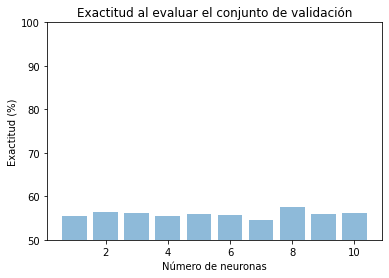

In [54]:
#Se crea el vector con el número de neuronas
neuronas = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500] 
acuraccy_bar=[]
j=0
#Se recorre la capa central
while(j<len(neuronas)):
  #Se crea y valida la red neuronal
  class_weights = np.array([0.1,0.1,1.0,j*1.0])
  RedNeuronal = crearRed(nInicial, neuronas[7], nSalida)
  #fit = RedNeuronal.fit(x_entrenamiento, y_entrenamiento, class_weight='balanced', batch_size=64, epochs=10, verbose=0)
  fit = RedNeuronal.fit(x_entrenamiento, y_entrenamiento, class_weight=class_weights, batch_size=64, epochs=10, verbose=0)
  score1, accuracy1 = RedNeuronal.evaluate(x_validacion, y_validacion, batch_size=50)
  y_predict = RedNeuronal.predict_classes(x_validacion)
  acuraccy_bar.append(accuracy1*100)
  target_names=['Despierto', 'Sueño ligero', 'Sueño profundo', 'Sueño REM']
  print(classification_report(y_valid_classes, y_predict, target_names=target_names))
  print("Precisión: ", accuracy1*100, "% ,", "Neuronas: ", '[',nInicial,',',neuronas[j],',',nSalida,']')
  j += 1
plt.bar (np.arange(1,len(acuraccy_bar)+1), acuraccy_bar, align = 'center' , alpha = 0.5 ) 
plt.ylim(50, 100)
plt.ylabel ( 'Exactitud (%)' ) 
plt.xlabel('Número de neuronas')
plt.title ( 'Exactitud al evaluar el conjunto de validación' )
plt.savefig("Modelo1.jpg", bbox_inches='tight')

#Se selecciona la red neuronal

1.   Se va a tomar la red con las neuronas [nInicial, 400, nSalida], dado que se observaron buenos resultados para este tipo de red.
2.   Se entrena la red con los datos de en trenamiento y esto luego de 5 epochs.
3.   Se guarda la red obtenida.



In [0]:
num=list(range(len(y_entrenamiento)))
y_entren_classes=[]
for i in num:
  y_entren_classes.append(np.argmax(y_entrenamiento[i]))
y_entren_classes = np.array(y_entren_classes)
class_weights = np.array([0.1,0.1,1.0,10.0])

In [56]:
#Se crea la red neuronal
RedNeuronal = crearRed(nInicial, 400, nSalida) 
#Se entrena la red
fit = RedNeuronal.fit(x_entrenamiento, y_entrenamiento,validation_data=(x_validacion, y_validacion), class_weight=class_weights ,batch_size=64, epochs=50, verbose=1)
#Se guarda la red creada
RedNeuronal.save("Punto1.h5py")

Train on 151192 samples, validate on 11106 samples
Epoch 1/50
151192/151192 [==============================] - 9s 60us/step - loss: 1.0839 - accuracy: 0.5142 - val_loss: 1.1230 - val_accuracy: 0.4784
Epoch 2/50
151192/151192 [==============================] - 8s 56us/step - loss: 0.9474 - accuracy: 0.5877 - val_loss: 1.0266 - val_accuracy: 0.5325
Epoch 3/50
151192/151192 [==============================] - 8s 56us/step - loss: 0.8983 - accuracy: 0.6084 - val_loss: 1.0435 - val_accuracy: 0.5106
Epoch 4/50
151192/151192 [==============================] - 8s 56us/step - loss: 0.8702 - accuracy: 0.6208 - val_loss: 1.0060 - val_accuracy: 0.5290
Epoch 5/50
151192/151192 [==============================] - 8s 56us/step - loss: 0.8498 - accuracy: 0.6318 - val_loss: 0.9673 - val_accuracy: 0.5615
Epoch 6/50
151192/151192 [==============================] - 8s 56us/step - loss: 0.8376 - accuracy: 0.6381 - val_loss: 0.9568 - val_accuracy: 0.5697
Epoch 7/50
151192/151192 [=============================

#Matriz de confusión y validación de red

In [57]:
y_obtenido = RedNeuronal.predict_classes(x_prueba)
N_datos = y_prueba.shape[0]
i = 0
y_true = []
y_pred = []
while(i<N_datos):
  y_true.append(np.argmax(y_prueba[i]))
  y_pred.append(y_obtenido[i])
  i = i+1
matriz_confusion = confusion_matrix(y_true, y_pred)
print(matriz_confusion)
print (classification_report(y_true, y_pred, target_names=target_names)) 

[[ 9842  4026   770  3564]
 [ 1194 11592  1061  4214]
 [  815  1472  2822   161]
 [  468  2380    22  3191]]
                precision    recall  f1-score   support

     Despierto       0.80      0.54      0.64     18202
  Sueño ligero       0.60      0.64      0.62     18061
Sueño profundo       0.60      0.54      0.57      5270
     Sueño REM       0.29      0.53      0.37      6061

      accuracy                           0.58     47594
     macro avg       0.57      0.56      0.55     47594
  weighted avg       0.63      0.58      0.59     47594



#Evaluación de la red neuronal
Una vez evaluado el error empirico y teniendo en cuenta el número de datos \\
Se observa que el indice de confianza es :
##$(1-\delta) = (1 - 2/\exp(|S{\small text}|{ \cdot 2\varepsilon^2 }))$

In [58]:
#Se prueba la red neuronal
prueba = RedNeuronal.evaluate(x_prueba, y_prueba, verbose=0)
#Se calcula el erro empirico, numero de datos y indice de confianza
E_empirico = 1 - prueba[1]
#confianza = 1 - 2/math.exp(N_datos*2*(E_empirico**2))
print('Número de datos de prueba = ' + str(N_datos))
print('Error empirico = ' + str(E_empirico))
#print('indice de confianza = ' + str(confianza))
#Resumen de la red
RedNeuronal.summary()

Número de datos de prueba = 47594
Error empirico = 0.42330968379974365
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_55 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 400)               80400     
_________________________________________________________________
dense_138 (Dense)            (None, 400)               160400    
_________________________________________________________________
dense_139 (Dense)            (None, 400)               160400    
_________________________________________________________________
dropout_56 (Dropout)         (None, 400)               0         
________________________________________________

#Aumentar el peso para sueño profundo

In [61]:
#Se asigna un peso de 100 para sueño profundo
class_weights = np.array([1.0, 1.0, 100.0, 1.0])
#Se crea la red neuronal
RedNeuronal = crearRed(nInicial, 400, nSalida) 
#Se entrena la red
fit = RedNeuronal.fit(x_entrenamiento, y_entrenamiento,validation_data=(x_validacion, y_validacion), class_weight=class_weights ,batch_size=64, epochs=50, verbose=1)

Train on 151192 samples, validate on 11106 samples
Epoch 1/50
151192/151192 [==============================] - 9s 60us/step - loss: 1.0822 - accuracy: 0.5164 - val_loss: 1.0955 - val_accuracy: 0.5120
Epoch 2/50
151192/151192 [==============================] - 9s 59us/step - loss: 0.9466 - accuracy: 0.5887 - val_loss: 1.0248 - val_accuracy: 0.5285
Epoch 3/50
151192/151192 [==============================] - 9s 58us/step - loss: 0.8969 - accuracy: 0.6104 - val_loss: 0.9947 - val_accuracy: 0.5430
Epoch 4/50
151192/151192 [==============================] - 9s 58us/step - loss: 0.8706 - accuracy: 0.6225 - val_loss: 0.9850 - val_accuracy: 0.5484
Epoch 5/50
151192/151192 [==============================] - 9s 58us/step - loss: 0.8516 - accuracy: 0.6310 - val_loss: 0.9734 - val_accuracy: 0.5556
Epoch 6/50
151192/151192 [==============================] - 9s 58us/step - loss: 0.8372 - accuracy: 0.6378 - val_loss: 0.9648 - val_accuracy: 0.5589
Epoch 7/50
151192/151192 [=============================

#Matriz de confusión y validación de red

In [62]:
y_obtenido = RedNeuronal.predict_classes(x_prueba)
N_datos = y_prueba.shape[0]
i = 0
y_true = []
y_pred = []
while(i<N_datos):
  y_true.append(np.argmax(y_prueba[i]))
  y_pred.append(y_obtenido[i])
  i = i+1
matriz_confusion = confusion_matrix(y_true, y_pred)
print(matriz_confusion)
print (classification_report(y_true, y_pred, target_names=target_names)) 

[[10508  3686   263  3745]
 [ 1715 11257   526  4563]
 [ 1365  1763  2007   135]
 [  543  2142    17  3359]]
                precision    recall  f1-score   support

     Despierto       0.74      0.58      0.65     18202
  Sueño ligero       0.60      0.62      0.61     18061
Sueño profundo       0.71      0.38      0.50      5270
     Sueño REM       0.28      0.55      0.38      6061

      accuracy                           0.57     47594
     macro avg       0.58      0.53      0.53     47594
  weighted avg       0.63      0.57      0.58     47594



#Analisis de resultados
Luego de ver el comportamiento de las redes se determio que:


1.   La red que peor describe las clsaes cuyos datos eran minoritarios fue la red no balanceada. De modo que, balancear la cantidad de datos es muy importante al momento de trabajar con clasificación
2.   Ademas se observó que modificar los pesos de las variables priorizando aquellas que carecian de datos, permitió obtener una red con una presición mucho más generalizada en las distintas clases.
3.   Por otro lado tambien se observó que al modificar los pesos teniendo en cuenta una unica variable, no fue conveniente. Ya que, esto le resto presición a las demas variables sin presentar una mejora significativa en esta unica variable.
4.   Finalmente, se observo que los resultados en general de las tres redes no son verdaderamente buenos. Esto se debe posiblemente a un problema con los descriptores, o con el tamaño de la red. Sin embargo, no se encontró una red que ofreciera un mejor resultado.



  #Referencias

1.   "sklearn.decomposition.PCA — scikit-learn 0.23.1 documentation", Scikit-learn.org, 2020. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html. [Accessed: 24- May- 2020].
2.   
"Home - Keras Documentation", Keras.io, 2020. [Online]. Available: https://keras.io/. [Accessed: 20- Mar- 2020].
